## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [ ]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [2]:
### Useful routines for preparing data
from numpy import array, zeros
import csv
import numpy as np
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

def load_imgs_and_keypoints(dirname='data'):
    # Write your code for loading images and points here
    csv_file = dirname + '/gt.csv'
    keypoint_list = list()
    imgs_list = list()
    with open(csv_file,newline='') as fcsv_file:
        csv_reader = csv.reader(fcsv_file)
        for row in csv_reader:
            if row[0] == 'filename':
                continue
            x_coord = row[1::2]
            y_coord = row[2::2]
            images_name = join(dirname,'images',row[0])
            img = imread(images_name)
            img_shape = img.shape
            x_coord_scaled = [float(x)/img_shape[1] - 0.5 for x in x_coord]
            y_coord_scaled = [float(x)/img_shape[0] - 0.5 for x in y_coord]
            xy_list = x_coord_scaled + y_coord_scaled
            xy_list[::2] = x_coord_scaled
            xy_list[1::2] = y_coord_scaled
            if len(img_shape)== 2 :
                color_img = np.zeros((img_shape[0],img_shape[1],3))
                color_img[:,:,0] = img
                color_img[:,:,1] = img
                color_img[:,:,2] = img
            else:
                color_img = img
            keypoint_list.append(xy_list)
            imgs_list.append(resize(color_img,(100,100)))
            
    return np.asarray(imgs_list),np.asarray(keypoint_list)

imgs, points = load_imgs_and_keypoints()

array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

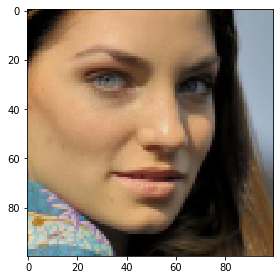

In [3]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

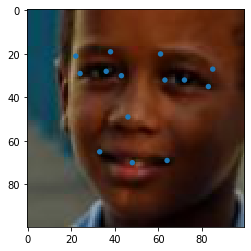

In [4]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig, ax = plt.subplots()
    im = ax.imshow(img)
    img_shape = img.shape
    patch = list()
    for i in range(0,len(points),2):
        x = int(round((points[i]+0.5)*img_shape[1]))
        y = int(round((points[i+1]+0.5)*img_shape[0]))
        patch.append(Circle((x,y),radius=1.25))
    p = PatchCollection(patch)
    ax.add_collection(p)
    plt.show()
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [5]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

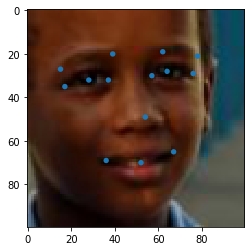

In [6]:
def flip_img(img, points):
    flipped_image = np.zeros_like(img)
    height,width,c = img.shape
    for i in range(height):
        for j in range(width):
            flipped_image[i,j,:] = img[i,width-1-j,:]
    f_points = points.copy()
    for i in range(0,points.shape[0],2):
        f_points[i]*= -1
    return flipped_image,f_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [7]:
def augment_data(imgs,points):
    aug_img = np.zeros((imgs.shape[0]*2,100,100,3))
    aug_points = np.zeros((points.shape[0]*2,28))
    for i in range(imgs.shape[0]):
        aug_img[2*i,...] = imgs[i]
        aug_points[2*i] = points[i]
        fimg, fpoints = flip_img(imgs[i],points[i])
        aug_img[2*i+1,...] = fimg
        aug_points[2*i+1] = fpoints
    return aug_img,aug_points
aug_imgs_train,aug_points_train  = augment_data(imgs_train,points_train)

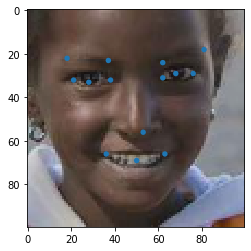

In [8]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

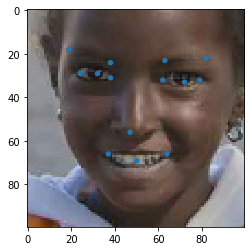

In [9]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [12]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)
from keras.regularizers import l2

reg = l2(0.001)
model = Sequential()
model.add(Conv2D(32,3,activation='relu',input_shape=(100,100,3)))
model.add(MaxPooling2D(pool_size=2,padding='valid'))

model.add(Conv2D(64,3,activation='relu'))
model.add(MaxPooling2D(pool_size=2,padding='valid'))

model.add(Conv2D(128,3,activation='relu'))
model.add(MaxPooling2D(pool_size=2,padding='valid'))

model.add(Flatten())
model.add(Dense(1024,activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(100,activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(28,activation='tanh'))

# Define here your model

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [13]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

optimizer = Adam(lr=0.001)
# Choose optimizer, compile model and run training
model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['accuracy'])
model.fit(imgs_train,points_train,epochs=20)

Epoch 1/20
5400/5400 [==============================] - 61s 11ms/step - loss: 0.0148 - acc: 0.3789
Epoch 2/20
5400/5400 [==============================] - 61s 11ms/step - loss: 0.0042 - acc: 0.6315
Epoch 3/20
5400/5400 [==============================] - 61s 11ms/step - loss: 0.0030 - acc: 0.7163
Epoch 4/20
5400/5400 [==============================] - 61s 11ms/step - loss: 0.0024 - acc: 0.7522
Epoch 5/20
5400/5400 [==============================] - 61s 11ms/step - loss: 0.0021 - acc: 0.7806
Epoch 6/20
5400/5400 [==============================] - 61s 11ms/step - loss: 0.0019 - acc: 0.7950
Epoch 7/20
5400/5400 [==============================] - 61s 11ms/step - loss: 0.0017 - acc: 0.7991
Epoch 8/20
5400/5400 [==============================] - 61s 11ms/step - loss: 0.0016 - acc: 0.8093
Epoch 9/20
5400/5400 [==============================] - 61s 11ms/step - loss: 0.0014 - acc: 0.8094
Epoch 10/20
5400/5400 [==============================] - 61s 11ms/step - loss: 0.0013 - acc: 0.8130
Epoch 11/

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

[[-0.38655674 -0.18933761 -0.18702996 -0.24191095  0.03065378 -0.28645262
   0.24757838 -0.34326926 -0.31485385 -0.11886033 -0.23393422 -0.14926949
  -0.16351742 -0.1504487   0.07642627 -0.20608877  0.13852143 -0.24963698
   0.21015918 -0.25497857  0.00794009  0.02658219 -0.1253054   0.18194687
   0.04701306  0.17906305  0.19720255  0.09373664]]


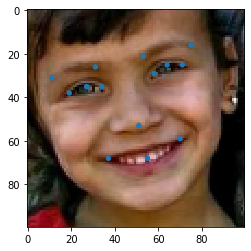

In [22]:
points = model.predict(imgs_val[0].reshape((1,100,100,3)))
print(points)
visualize_points(imgs_val[0],points[0])

[[-0.31151155 -0.27174076 -0.11828203 -0.2806538   0.0908367  -0.28091565
   0.29807144 -0.28031942 -0.2598544  -0.19301794 -0.18546315 -0.19276258
  -0.11636242 -0.18680383  0.10797772 -0.18530352  0.18475133 -0.19975981
   0.25500056 -0.19722858 -0.01830338  0.02579268 -0.1423934   0.1750821
  -0.00358198  0.18655069  0.14812586  0.16980584]]


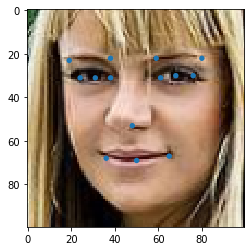

In [167]:
points = model.predict(imgs_val[10].reshape((1,100,100,3)))
print(points)
visualize_points(imgs_val[10],points[0])

[[-0.32971266 -0.06626223 -0.2378239  -0.17942776 -0.12693371 -0.28673315
   0.04652498 -0.38616574 -0.27374625 -0.00906061 -0.22424781 -0.06503879
  -0.18927354 -0.08146612 -0.02411358 -0.20367001  0.00167824 -0.23605919
   0.07430007 -0.2586913  -0.09244014 -0.04735191 -0.05420168  0.20616111
   0.03894433  0.11880357  0.16750696  0.04592699]]


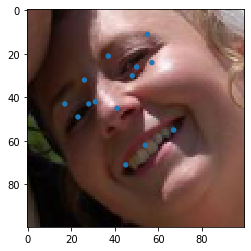

In [161]:
index = 113

points = model.predict(imgs_val[index].reshape((1,100,100,3)))
print(points)
visualize_points(imgs_val[index],points[0])